<a href="https://colab.research.google.com/github/chiyeon01/CNN_Model_Mechanism/blob/main/pytorch/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 36.3 MB/s eta 0:00:00


In [31]:
# Module import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.optim import SGD, Adagrad, RMSprop, Adam, AdamW
import torchmetrics

import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Test Module
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

In [4]:
# Config & Settings
class Config:
    batch_size = 16
    FineTune = False
    shuffle = False
    first_learning_rate = 1e-3
    second_learning_rate = 1e-4
    image_size = [224, 224] # 이미지는 3채널로 간주(image is 3 channels)
    model_name = 'efficientnet_b0'
    make_summary = False
    callbacks = []
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
    classifier_layer = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=1280, out_features=10)
        )

In [5]:
# 사전학습된 모델을 만드는 함수(create pretrained model function)
# 모든 가중치는 DEFAULT로 선언(all weights = 'DEFAULT')
def create_pretrained_model(model_name='alexnet', classifier_layer=None, make_summary=False):
    if model_name == 'alexnet':
        model = models.alexnet(weights='DEFAULT')
    elif model_name == 'resnet50':
        model = models.resnet50(weights='DEFAULT')
    elif model_name == 'resnet101':
        model = models.resnet101(weights='DEFAULT')
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='DEFAULT')
        model.classifier = classifier_layer
    elif model_name == 'efficientnet_b4':
        model = models.efficientnet_b4(weights='DEFAULT')
    elif model_name == 'efficientnet_v2_s':
        model = models.efficientnet_v2_s(weighs='DEFAULT')
    elif model_name == 'efficientnet_v2_m':
        model = models.efficientnet_v2_m(weighs='DEFAULT')
    elif model_name == 'efficientnet_v2_l':
        model = models.efficientnet_v2_l(weighs='DEFAULT')
    elif model_name == 'convnext_base':
        model = models.convnext_base(weights='DEFAULT')
    elif model_name == 'convnext_small':
        model = models.convnext_small(weights='DEFAULT')
    else:
        print("🧨🧨 [ERROR] 모델 이름이 존재하지 않습니다. 🧨🧨")
        return None

    if make_summary:
        # 모델 정보 요약(model summary)
        print(torchinfo.summary(model, input_size=[1, 3] + Config.image_size,
                  col_names=['output_size', 'num_params', 'trainable'],
                  row_settings=['depth', 'var_names'],
                  depth=3))

    return model

In [14]:
# 1번 에포크 학습 함수(1 epoch train function)
def train_epoch(model=None, dataloader=None, loss_fn=None, metric=False, optimizer=None):
    if dataloader == None:
        print("🧨🧨 [ERROR] 데이터로더가 존재하지 않습니다. 🧨🧨")
        return None

    device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

    model = model.to(device)
    metric = metric.to(device)

    # 평균 loss를 구하기 위한 변수(variable for average loss)
    avg_loss = 0
    sum_loss = 0

    # 모델 학습 설정(model train setting)
    model.train()

    with tqdm(total = len(dataloader), desc="[Training...] ", leave=True) as progress_bar:
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = loss_fn(logits, labels)
            sum_loss += loss.item()
            avg_loss = sum_loss / (batch_idx+1)

            acc = metric(F.softmax(logits, dim=-1).argmax(dim=-1), labels)

            # 옵티마이저 초기화(optimizer initialize)
            optimizer.zero_grad()

            # 오차역전파 계산(backpropagation)
            loss.backward()

            # 학습 파라미터 업데이트(parameter Update)
            optimizer.step()

            # Progress bar Update
            progress_bar.update(1)

            if batch_idx % 20 == 0:
                # Progress_bar Update -> set_postfix
                progress_bar.set_postfix({
                    "Train_Loss" : avg_loss,
                    "Train_Accuracy" : metric.compute().item()
                    })

        metric.reset()

In [15]:
# 1번 에포크 학습 함수(1 epoch train function)
def validate_epoch(model=None, dataloader=None, loss_fn=None, metric=False):
    if dataloader == None:
        print("🧨🧨 [ERROR] 데이터로더가 존재하지 않습니다. 🧨🧨")
        return None

    device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

    model = model.to(device)
    metric = metric.to(device)

    # 평균 loss를 구하기 위한 변수(variable for average loss)
    avg_loss = 0
    sum_loss = 0

    # 모델 평가로 설정(model evaluation setting)
    model.eval()

    with tqdm(total = len(dataloader), desc="[Validating..] ", leave=True) as progress_bar:
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = loss_fn(logits, labels)
            sum_loss += loss.item()
            avg_loss = sum_loss / (batch_idx+1)

            acc = metric(F.softmax(logits, dim=-1).argmax(dim=-1), labels)

            # Progress bar Update
            progress_bar.update(1)

            if batch_idx % 20 == 0:
                # Progress_bar Update -> set_postfix
                progress_bar.set_postfix({
                    "Validate_Loss" : avg_loss,
                    "Validate_Accuracy" : metric.compute().item()
                    })

        metric.reset()

In [16]:
def fit(epochs=1, model=None, dataloader=None, loss_fn=None, metric=False, optimizer=None):
    history = {
        'train_loss' : [],
        'val_loss' : [],
        'train_metric' : [],
        'val_metric' : []
    }

    for epoch in range(1, epochs+1):
        train_loss, train_metric = train_epoch(model=model, dataloader=dataloader, loss_fn=loss_fn, metric=metric, optimizer=optimizer)
        val_loss, val_metric = validate_epoch(model=None, dataloader=None, loss_fn=None, metric=False)

        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss); history['train_metric'].append(train_metric); history['val_metric'].append(val_metric)

    return history

In [17]:
####### test #######

# transform 생성
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# 데이터셋
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=Config.batch_size, shuffle=Config.shuffle, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=Config.batch_size, shuffle=False, pin_memory=True)

model = create_pretrained_model(model_name=Config.model_name, classifier_layer=Config.classifier_layer, make_summary=Config.make_summary)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=Config.first_learning_rate)

train_epoch(model, train_dataloader, loss_fn, Config.metric, optimizer)
validate_epoch(model, test_dataloader, loss_fn, Config.metric)

[Validating..] : 100%|██████████| 625/625 [00:11<00:00, 56.61it/s, Validate_Loss=0.453, Validate_Accuracy=0.854]


In [28]:
class Trainer:
    def __init__(self, model=None, train_dataloader=None, val_dataloader=None, loss_fn=None, metric=False, optimizer=None):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.loss_fn = loss_fn
        self.metric = metric
        self.optimizer = optimizer

    # 1번 에포크 학습 함수(1 epoch train function)
    def train_epoch(self):
        device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

        self.model = self.model.to(device)
        self.metric = self.metric.to(device)

        # 평균 loss를 구하기 위한 변수(variable for average loss)
        avg_loss = 0
        sum_loss = 0

        # 모델 학습 설정(model train setting)
        self.model.train()

        with tqdm(total = len(self.train_dataloader), desc="[Training...] ", leave=True) as progress_bar:
            for batch_idx, (images, labels) in enumerate(self.train_dataloader):
                images = images.to(device)
                labels = labels.to(device)

                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                sum_loss += loss.item()
                avg_loss = sum_loss / (batch_idx+1)

                avg_metric = self.metric(F.softmax(logits, dim=-1).argmax(dim=-1), labels).item()

                # 옵티마이저 초기화(optimizer initialize)
                self.optimizer.zero_grad()

                # 오차역전파 계산(backpropagation)
                loss.backward()

                # 학습 파라미터 업데이트(parameter Update)
                self.optimizer.step()

                # Progress bar Update
                progress_bar.update(1)

                if batch_idx % 20 == 0 or batch_idx+1 == len(self.train_dataloader):
                    # Progress_bar Update -> set_postfix
                    progress_bar.set_postfix({
                        "Train_Loss" : avg_loss,
                        "Train_Accuracy" : avg_metric
                        })

            self.metric.reset()

        return avg_loss, avg_metric

    # 1번 에포크 학습 함수(1 epoch train function)
    def validate_epoch(self):
        device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

        self.model = self.model.to(device)
        self.metric = self.metric.to(device)

        # 평균 loss를 구하기 위한 변수(variable for average loss)
        avg_loss = 0
        sum_loss = 0

        # 모델 평가로 설정(model evaluation setting)
        self.model.eval()

        with tqdm(total = len(self.val_dataloader), desc="[Validating..] ", leave=True) as progress_bar:
            for batch_idx, (images, labels) in enumerate(self.val_dataloader):
                images = images.to(device)
                labels = labels.to(device)

                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                sum_loss += loss.item()
                avg_loss = sum_loss / (batch_idx+1)

                avg_metric = self.metric(F.softmax(logits, dim=-1).argmax(dim=-1), labels).item()

                # Progress bar Update
                progress_bar.update(1)

                if batch_idx % 20 == 0 or batch_idx+1 == len(self.train_dataloader):
                    # Progress_bar Update -> set_postfix
                    progress_bar.set_postfix({
                        "Validate_Loss" : avg_loss,
                        "Validate_Accuracy" : avg_metric
                        })

            self.metric.reset()

        return avg_loss, avg_metric

    # fit(train_epochs and val_epochs)
    def fit(self, epochs):
        history = {
            'train_loss' : [],
            'val_loss' : [],
            'train_metric' : [],
            'val_metric' : []
        }

        for epoch in range(1, epochs+1):
            train_loss, train_metric = self.train_epoch()
            val_loss, val_metric = self.validate_epoch()

            history['train_loss'].append(train_loss); history['val_loss'].append(val_loss); history['train_metric'].append(train_metric); history['val_metric'].append(val_metric)

        return history

    # 마지막으로 학습된 모델 반환(return final trained model)
    def get_trained_model(self):
        return self.model

In [29]:
# Trainer 클래스 사용 예시(example)
model = create_pretrained_model(model_name=Config.model_name, classifier_layer=Config.classifier_layer, make_summary=Config.make_summary)

# transform 생성
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# 데이터셋
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=Config.first_learning_rate)

trainer = Trainer(model=model, train_dataloader=train_dataloader, val_dataloader=test_dataloader,
                  loss_fn=loss_fn, metric=Config.metric, optimizer=optimizer)

history = trainer.fit(10)

[Validating..] : 100%|██████████| 625/625 [00:10<00:00, 56.90it/s, Validate_Loss=0.306, Validate_Accuracy=0.938]


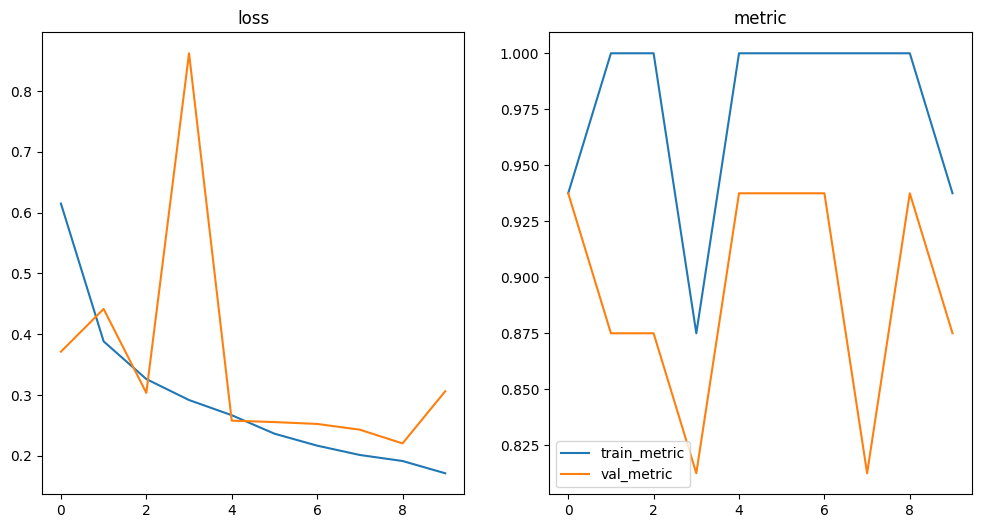

In [44]:
# 학습 과정 시각화하는 함수(function show history)
def show_history_chart(history):
    fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
    axs[0].plot(history['train_loss'], label='train_loss')
    axs[0].plot(history['val_loss'], label='val_loss')
    axs[0].set_title('loss')
    axs[1].plot(history['train_metric'], label='train_metric')
    axs[1].plot(history['val_metric'], label='val_metric')
    axs[1].set_title('metric')
    plt.legend()

show_history_chart(history)